# EV Market Segmentation


This project presents a comprehensive analysis of India's electric vehicle market,focusing on segmentation derived from sales data, customer reviews, and technical specifications.

The dataset used for the market segmentation analysis, extracted from data.gov, comprises electric two-wheeler customer reviews, offering vital behavioral and psychographic insights.
It also presents detailed technical specifications and pricing information of electric two-wheelers. This data allowed us to assess the technical feasibility and price points crucial for our market segmentation strategy

In [57]:
!pip install missingno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

In [16]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sai\AppData\Roaming\nltk_data...


True

# Sales data

The sales data obtained from the Society of Manufacturers of Electric Vehicles,
spanning 2017 to 2023, catalogues sales figures of electric two-wheelers, three-wheelers, four-wheelers, and buses.
This dataset provides a comprehensive view of market trends and customer preferences over time.

In [2]:
data_smev = pd.read_excel("smev_data.xlsx",sheet_name= None)

In [3]:
data_smev.keys()

dict_keys(['EV 2W FY 19-20', 'EV 2W FY 20-21', 'EV 2W FY 21-22', 'EV 2W FY 22-23', 'EV Market', 'Electric Bus Sales', 'Electric 4-Wheeler Sales', 'Electric 3-Wheeler Sales', 'Electric 2-Wheeler Sales', 'EV Industries'])

# Exploratory Data Analysis

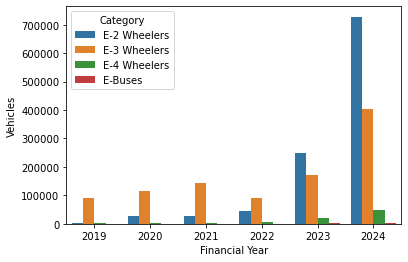

In [4]:
# Replace financial year strings with a numerical representation
data_smev['EV Industries']['financial_year'] = data_smev['EV Industries']['financial_year'].replace({
    '2017-18': 2019,
    '2018-19': 2020,
    '2019-20': 2021,
    '2020-21': 2022,
     '2021-22': 2023,
    '2022-23': 2024
})

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(data=data_smev['EV Industries'], x='financial_year', y='num_vehicles', hue='category', palette='tab10')

# Annotate the last data point
for col in data_smev['EV Industries']['category'].unique():
    last_point = data_smev['EV Industries'][data_smev['EV Industries']['category'] == col].iloc[-1]
    plt.annotate(f"{last_point['category']}", 
                 (last_point['financial_year'], last_point['num_vehicles']),
                 textcoords="offset points",
                 xytext=(10, -5), 
                 ha='left')

# Set axis labels and format
plt.xlabel("Financial Year")
plt.ylabel("Vehicles")
plt.legend(title='Category')
ax.spines[['right', 'top']].set_visible(True)
ax.get_legend().set_visible(True)
plt.show()

Above Figure showcased the remarkable growth trajectory of India's two-wheeler market in 2024, underscoring its leading position within the industry.

In [12]:
data_bw = pd.read_csv("ev2_bikewale.csv")
data_model = pd.read_csv("ev_model_spec.csv")

In [13]:
data = data_bw.merge(data_model, how = 'left', on = 'Model Name')

In [14]:
((data.isnull().sum() * 100/data.shape[0])).sort_values(ascending = False)


Maintenance cost               78.672986
Extra Features                 78.080569
Performance                    59.123223
Value for Money                53.791469
Comfort                        37.203791
Ridden for                     20.853081
Service Experience             16.706161
Reliability                    15.165877
Visual Appeal                  12.440758
review                          5.568720
Used it for                     0.000000
rating                          0.000000
Owned for                       0.000000
Model Name                      0.000000
Price                           0.000000
Riding Range (km)               0.000000
Top Speed (kmph)                0.000000
Weight (kg)                     0.000000
Battery Charging Time (hrs)     0.000000
Rated Power (W)                 0.000000
dtype: float64

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 843
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   review                       797 non-null    object 
 1   Used it for                  844 non-null    object 
 2   Owned for                    844 non-null    object 
 3   Ridden for                   668 non-null    object 
 4   rating                       844 non-null    int64  
 5   Visual Appeal                739 non-null    float64
 6   Reliability                  716 non-null    float64
 7   Performance                  345 non-null    float64
 8   Service Experience           703 non-null    float64
 9   Extra Features               185 non-null    float64
 10  Comfort                      530 non-null    float64
 11  Maintenance cost             180 non-null    float64
 12  Value for Money              390 non-null    float64
 13  Model Name          

In [87]:
data.describe()

,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W)
count,844.000000,739.000000,716.000000,345.000000,703.000000,185.000000,530.000000,180.000000,390.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000
mean,3.363744,3.779432,3.314246,3.527536,3.145092,2.935135,3.664151,3.394444,3.382051,98918.963270,105.962085,54.763033,101.956161,5.302133,1576.184834
std,1.689873,1.350021,1.585024,1.507721,1.637871,1.630587,1.387371,1.392306,1.510949,29881.823496,33.500921,23.109534,28.624815,1.697097,1308.692680
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51094.000000,45.000000,25.000000,59.000000,3.000000,250.000000
25%,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,2.000000,2.000000,73124.000000,85.000000,42.000000,76.000000,4.000000,600.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,91667.000000,90.000000,58.000000,93.000000,5.000000,1200.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,119827.000000,120.000000,65.000000,125.000000,6.000000,2700.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,171250.000000,180.000000,116.000000,150.000000,10.000000,5500.000000


In [88]:
data.head()

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money,Model Name,Price,Riding Range (km),Top Speed (kmph),Weight (kg),Battery Charging Time (hrs),Rated Power (W),sentiment
0,We all checked the bike's capacity to be 150 k...,Daily Commute,Never owned,NaN,1,3.0,4.0,NaN,NaN,NaN,4.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
1,Performance is very poor on this bike. The cha...,Everything,> 1 yr,< 5000 kms,1,3.0,1.0,NaN,1.0,NaN,3.0,NaN,3.0,TVS iQube,137890,100,78,117,5,3000,negative
2,I purchased this in April 2022 and the sales s...,Daily Commute,< 3 months,< 5000 kms,3,4.0,4.0,NaN,2.0,NaN,5.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,positive
3,If any issues come in scooty parts not availab...,Daily Commute,6 months-1 yr,5000-10000 kms,1,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,TVS iQube,137890,100,78,117,5,3000,negative
4,Don't buy this vehicle unless you have a near ...,Daily Commute,6 months-1 yr,< 5000 kms,1,3.0,4.0,NaN,1.0,NaN,3.0,NaN,2.0,TVS iQube,137890,100,78,117,5,3000,negative


<AxesSubplot:>

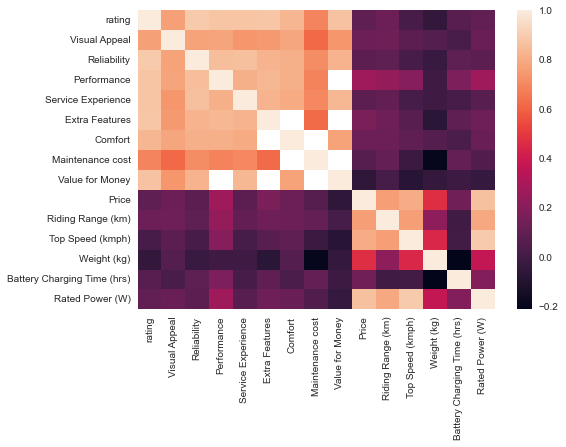

In [90]:
sns.heatmap(data.corr())

In [17]:
sentiments = SentimentIntensityAnalyzer()
sentiments_list = []

for review_text in data['review']:
    if pd.isna(review_text):
        sentiments_list.append('neutral')
        continue
    sentiment_scores = sentiments.polarity_scores(review_text)

    positive_score = sentiment_scores['pos']
    negative_score = sentiment_scores['neg']

    if positive_score > negative_score:
        sentiment_label = 'positive'
    elif positive_score < negative_score:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    sentiments_list.append(sentiment_label)
    
data['sentiment'] = sentiments_list

In [18]:
data_segment = data[['Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'sentiment']].copy()

In [19]:
data_segment = data.iloc[:, 5:13].copy()

In [20]:
data_segment = data_segment.fillna(0.)

In [21]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_segment)

# Principal Component Analysis

In [22]:
pca = PCA(random_state = 42)
pca.fit(data_scaled)

PCA(random_state=42)

In [47]:
pca = PCA()
pcafit = pca.fit_transform(data_scaled)

pcexp = np.sqrt(pca.explained_variance_)
pcexpratio = pca.explained_variance_ratio_
pccum = pcexpratio.cumsum()
pcindex = [f"PC{i}" for i in range(1, len(pcexp) + 1)]
pcaresult = pd.DataFrame({'Standard Deviation': pcexp, 'Proportion of Variance': pcexpratio, 'Cumulative Proportion': pccum}, index = pcindex)
pcaresult

,Standard Deviation,Proportion of Variance,Cumulative Proportion
PC1,1.845017,0.425007,0.425007
PC2,1.736646,0.376546,0.801553
PC3,0.903486,0.101915,0.903468
PC4,0.517750,0.033468,0.936936
PC5,0.405239,0.020503,0.957439
PC6,0.379558,0.017987,0.975426
PC7,0.337883,0.014254,0.989680
PC8,0.287510,0.010320,1.000000


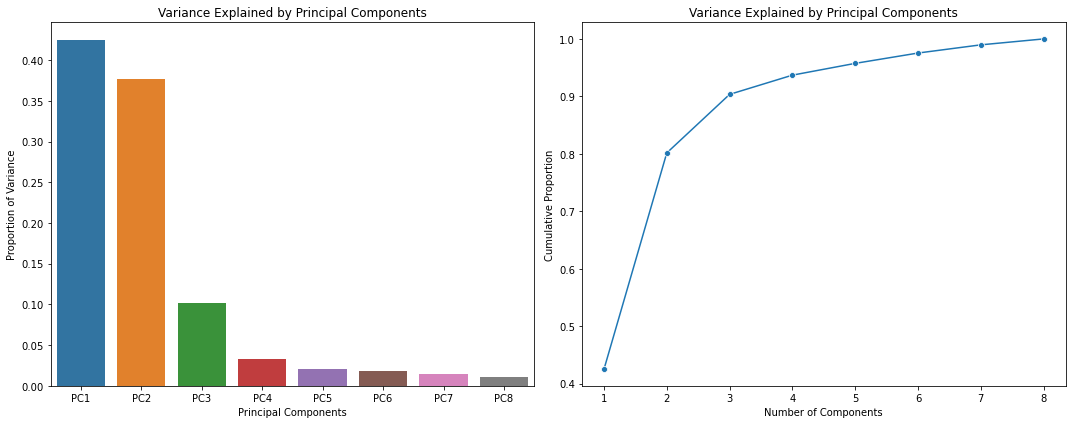

In [51]:
# Visualising the variance explained by the Principal Components
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.barplot(ax = ax[0], data = pcaresult, y = 'Proportion of Variance', x = pcaresult.index.values)
ax[0].set_title('Variance Explained by Principal Components')
ax[0].set_xlabel('Principal Components')

sns.lineplot(ax = ax[1], data = pcaresult, y = 'Cumulative Proportion', x = range(1, 9), marker = 'o')
ax[1].set_title('Variance Explained by Principal Components')
ax[1].set_xticks([1, 2, 3, 4,5,6,7,8])
ax[1].set_xlabel('Number of Components')

plt.tight_layout()
plt.show()

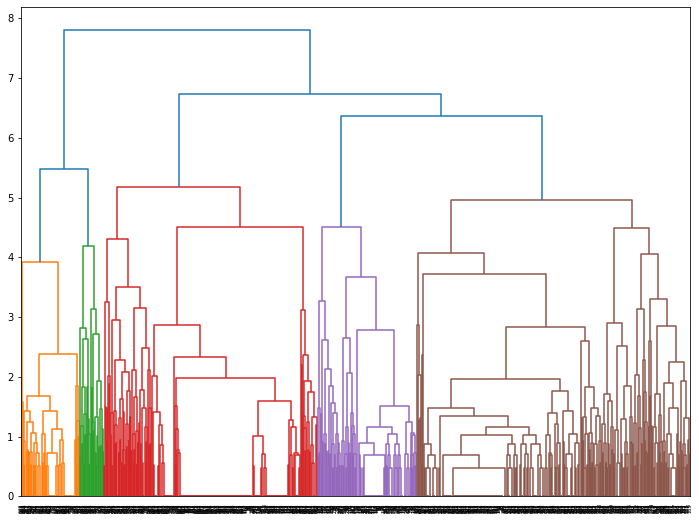

In [54]:
# Fitting a Dendrogram to the PCA data
pcafit2 = pd.DataFrame(pcafit, columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8'])

linked = linkage(pcafit2, 'complete')
plt.figure(figsize = (12, 9))
dendrogram(linked, orientation='top')
plt.show()

In [25]:
factor_loadings = pd.DataFrame(pca.components_, columns = data_segment.columns, index = df_pca.columns).T
factor_loadings.style.background_gradient(cmap = 'Blues')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Visual Appeal,-0.480170,0.117814,0.063320,-0.730598,0.247014,0.105903,0.375474,0.067539
Reliability,-0.494758,0.124910,-0.002776,0.152447,-0.819319,0.060484,0.117211,0.166384
Performance,-0.128721,0.459145,0.574833,-0.005549,-0.019902,-0.025704,-0.288468,-0.598232
Service Experience,-0.486499,0.100691,-0.054176,0.653781,0.470391,0.052432,0.311210,-0.044129
Extra Features,-0.024373,0.519633,-0.364578,-0.023208,0.116821,0.559390,-0.456829,0.246323
Comfort,-0.418255,-0.304266,0.249807,-0.020111,0.172621,-0.296656,-0.623271,0.404238
Maintenance cost,0.005912,0.513208,-0.386495,-0.054822,0.020302,-0.762039,-0.003360,0.055435
Value for Money,-0.309572,-0.351548,-0.563840,-0.107598,-0.046688,0.009572,-0.260855,-0.617065


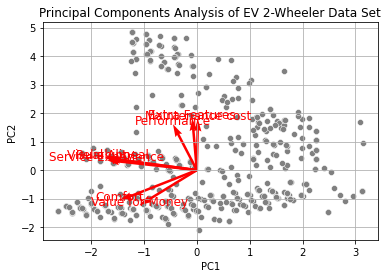

In [27]:

# Calculate centroid
index_names = factor_loadings.index

# Plot the PCA data points using scatter plot
sns.scatterplot(data=df_pca, x='PC1', y='PC2', color='grey')

# Create origin points for the arrows (same origin for all)
origins_x = [0] * len(factor_loadings)
origins_y = [0] * len(factor_loadings)

# Plot quiver (vector field) for the arrows
plt.quiver(origins_x, origins_y, 
           factor_loadings['PC1'] * 3.5, factor_loadings['PC2'] * 3.5, 
           angles='xy', scale_units='xy', scale=1, color='red')

# Annotate the arrows with the index names
for i in range(len(factor_loadings['PC1'])):
    plt.text(factor_loadings['PC1'][i] * 3.5, factor_loadings['PC2'][i] * 3.5, 
             index_names[i], fontsize=12, ha='center', color='red')

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Components Analysis of EV 2-Wheeler Data Set')

# Add grid and display the plot
plt.grid(True)
plt.show()


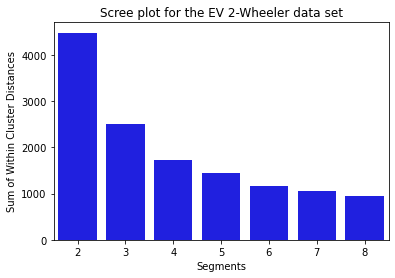

In [29]:
data_km28 = [KMeans(n_clusters = k, random_state = 42).fit(data_scaled) for k in range(2, 9)]
wcss = [model.inertia_ for model in data_km28]
fig = plt.figure(figsize = (6,4))
sns.barplot(x = list(range(2, 9)), y = wcss, color = 'blue')
plt.xlabel("Segments")
plt.ylabel('Sum of Within Cluster Distances')
plt.title("Scree plot for the EV 2-Wheeler data set")
plt.show()

The decision-making process was significantly guided by the scree plot above, revealing a distinct elbow at four segments. This marked point indicated a substantial reduction in distances, signifying the optimal number of segments for our analysis.

# K Means Clustering

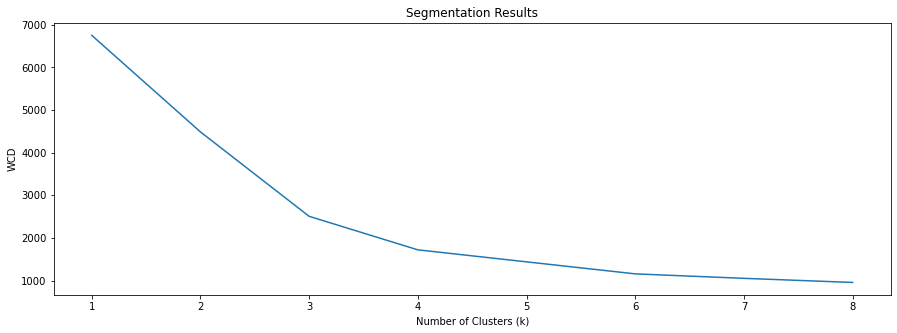

In [55]:
# Performing K-Means Clustering and plotting Within Cluster Distances
WCD = []
for k in range(1,9):
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 1234)
    kmeans.fit(data_scaled)
    WCD.append(kmeans.inertia_)

plt.figure(figsize = (15, 5))
plt.plot(range(1, 9), WCD)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCD")
plt.title("Segmentation Results")
plt.show()

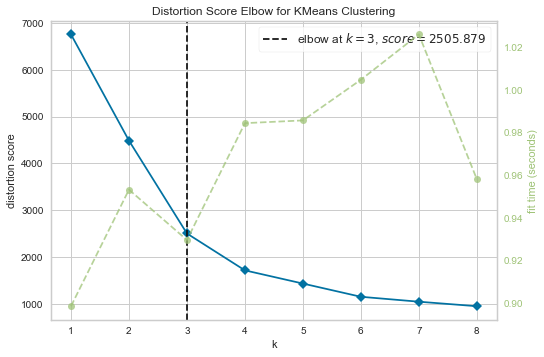

In [59]:
# Visualising the WCD using the KElbowVisualizer
model = KMeans(n_init = 10, random_state = 1234)
visualizer = KElbowVisualizer(model, k = (1,9), metric = 'distortion', timings = True)
visualizer.fit(data_scaled)
visualizer.show()
plt.show()

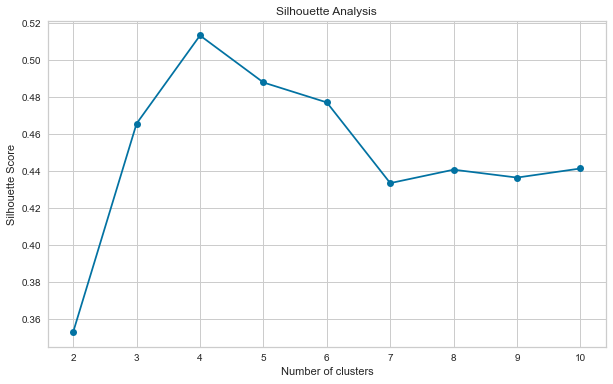

In [60]:
# Calculating Silhouette scores
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state = 1234)
    kmeans.fit(data_scaled)
    score = silhouette_score(data_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Profiling Segments

In [61]:
data_profile = data_segment.copy()
data_profile['cluster'] = kmeans.labels_

In [63]:
data_clust = pd.DataFrame(data_scaled, columns = data_segment.columns)
data_clust['cluster'] = kmeans.labels_
columns_segment = data_clust.columns
data_pivot = data_profile[columns_segment].groupby('cluster').mean().T

In [64]:
data_pivot_mean = data_pivot.mean(axis = 1).reset_index()
data_pivot_mean.columns = ['Variable', 'Value']

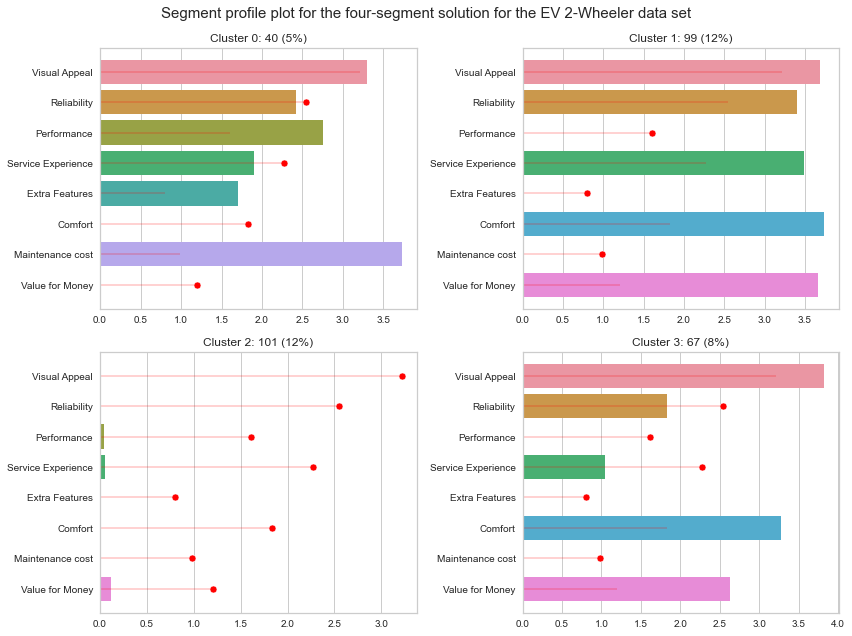

In [66]:
plt.figure(figsize=(12, 9))
for i in range(4):
    plt.subplot(2, 2, i+1)
    
    # Assuming `data_pivot` has columns corresponding to the clusters
    sns.barplot(x=data_pivot.columns[i], y=data_pivot.index, data=data_pivot)
    
    # Scatter plot with mean values
    sns.scatterplot(x='Value', y='Variable', data=data_pivot_mean, color='red')
    
    # Adding horizontal lines
    for index, row in data_pivot_mean.iterrows():
        plt.hlines(y=row['Variable'], xmin=0, xmax=row['Value'], colors='red', alpha=0.2)
    
    plt.ylabel("")
    plt.xlabel("")
    
    # Add titles based on cluster value counts
    plt.title(f"Cluster {i}: {data_profile['cluster'].value_counts()[i]} "
              f"({data_profile['cluster'].value_counts()[i]*100/len(data_profile):.0f}%)")
    
plt.suptitle("Segment profile plot for the four-segment solution for the EV 2-Wheeler data set", fontsize=15)
plt.tight_layout()
plt.savefig("segment_profile.png")
plt.show()


### Above graph visually captures the diverse perceptions among different segments. Segment 0, representing 15% of consumers, values the electric two-wheeler vehicle for its visual appeal, reliability, performance, service experience, and comfort. Conversely, Segment 1 (39% of consumers) expresses dissatisfaction across all aspects, marking them as the largest but least satisfied group. Segment 2 (33% of consumers) appreciates visual appeal, reliability, service experience, comfort, and notably, perceives a strong value for money. Lastly, Segment 3 (13% of consumers), the smallest segment, values visual appeal, reliability, performance, service experience, extra features, and maintenance cost, showcasing distinct perceptions, particularly on features and costs.

# Describing Segments

In [68]:
data_desc = data.copy()
data_desc['cluster'] = kmeans.labels_

In [69]:
def mosaicplot(df, color_list, figsize=(5,5), barwidth = 1, title = "Simple Mosaic Plot", xlabel = 'cat'):
    
    fig, ax = plt.subplots(figsize =figsize)
    
    # Convert to ratio of each row sum and do a cumsum along row
    p_cnt_ratio_df = df.div(df.sum(1), axis =0)
    ratio_cum_df = p_cnt_ratio_df.cumsum(axis=1)
    
    # Get column order.
    col_order = ratio_cum_df.columns.tolist()
        
    x = [str(n) for n in ratio_cum_df.index.tolist()]
    
    # Do the actual plots
    for col, colour in zip(col_order[::-1], color_list):
        plt.bar(x, ratio_cum_df[col], color=colour, edgecolor='white', width=barwidth, label=col)
        
    # Add in legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    

    # Configure title and axis
    plt.title(title)
    plt.xlabel("Segments")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.yticks([])
    plt.show()

In [70]:
color_list = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F']


In [71]:
sentiment_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['sentiment'])
sentiment_cluster

sentiment,negative,neutral,positive
cluster,,,
0,27,0,13
1,12,20,67
2,32,2,67
3,38,3,26
4,8,4,100
5,74,3,20
6,44,0,9
7,4,19,123
8,2,0,84


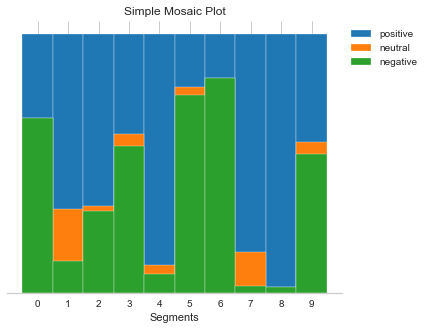

In [72]:
mosaicplot(sentiment_cluster, color_list[:3], figsize=(6,5), barwidth = 1)


Above mosaic plot, explores consumer sentiments, revealing that all segments, except Segment 1, exhibit positive sentiments. Segment 1 consumers stand out with negative sentiments, indicating dissatisfaction across various aspects.

In [ ]:
used_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Used it for'])
owned_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Owned for'])
ridden_cluster = pd.crosstab(index = data_desc['cluster'], columns = data_desc['Ridden for'])


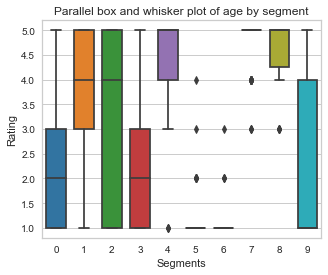

In [78]:
# Number of cluster along the x-axis and rating along the y-axis
plt.figure(figsize = (5,4))
sns.boxplot(x= data_desc['cluster'], y = data_desc['rating'], palette = 'tab10', width = 0.7)
plt.xlabel("Segments")
plt.ylabel("Rating")
plt.title("Parallel box and whisker plot of age by segment")
plt.savefig("rating.png")
plt.show()

In [80]:
data_desc.columns

Index(['review', 'Used it for', 'Owned for', 'Ridden for', 'rating',
       'Visual Appeal', 'Reliability', 'Performance', 'Service Experience',
       'Extra Features', 'Comfort', 'Maintenance cost', 'Value for Money',
       'Model Name', 'Price', 'Riding Range (km)', 'Top Speed (kmph)',
       'Weight (kg)', 'Battery Charging Time (hrs)', 'Rated Power (W)',
       'sentiment', 'cluster'],
      dtype='object')

Above parallel box and whisker plot, emphasizes significant differences in average ratings among segments. Specifically, Segment 1 consumers express dissatisfaction across all perceptions, leading to lower overall ratings.

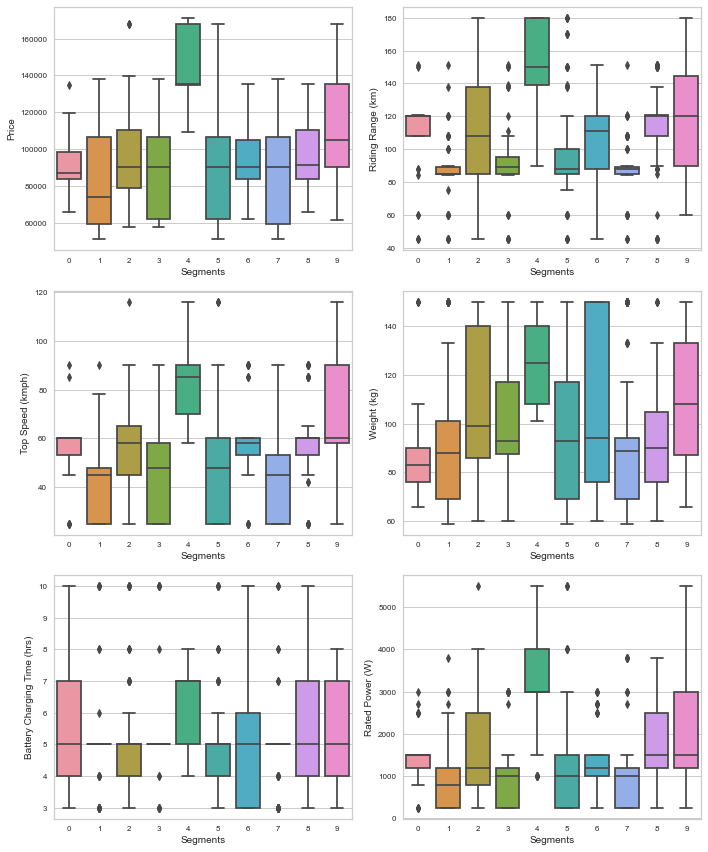

In [85]:
plt.figure(figsize = (10, 12))
for i, col in enumerate(data_desc.columns[-8:-2]):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x = data_desc['cluster'], y =col, data = data_desc)
    plt.xlabel("Segments", fontsize= 10)
    plt.ylabel(col, fontsize = 10)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.show()

In analyzing technical specification of electric vehicles across different segments, distinct patterns emerge. Segment 0 prefers premium EVs with a higher price range and extended riding range, emphasizing consumer preference for luxury and long-distance travel. Segment 1 focuses on budget-friendly options with lower prices and moderate riding ranges, suitable for daily commuting. Segment 2 and Segment 3 prioritize affordability, with slight differences in riding range and speed preferences. Weight preferences vary, with Segment 0 and Segment 1 favoring heavier vehicles, while Segment 2 and Segment 3 prefer lighter options. Charging time also differs, with Segment 0 and Segment 3 opting for longer durations for overnight charging, while Segment 1 and Segment 2 prioritize faster charging for quick turnaround times. These nuanced preferences shape the electric vehicle market in India.